# GRU

the following link has been used for developing the code:
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from itertools import groupby
from operator import itemgetter
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
line=[]
with open(str("./Desktop/ferdousi.txt"), encoding = 'utf-8') as file:
            line = [line.rstrip() for line in file]

In [8]:
lines=[line[2*x+2]+" "+line[2*x+3] for x in range(49608)]

In [9]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

In [10]:
pairs=[]
for i in range(len(lines)-1):
    a=[lines[i],lines[i+1]]
    pairs.append(a)
    

In [11]:
dictionary=Lang("words")
for i in range(len(lines)):
    dictionary.addSentence(lines[i])
    
    

In [12]:
len(dictionary.word2index)

18011

In [13]:
MAX_LENGTH=max([len(lines[i].split(" ")) for i in range(len(lines))])
    

In [14]:
MAX_LENGTH

20

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dictionary, pair[0])
    target_tensor = tensorFromSentence(dictionary, pair[1])
    return (input_tensor, target_tensor)


In [18]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
       
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [37]:

plot_losses = []

In [38]:

def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    global plot_losses
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%d %f %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    

In [39]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(dictionary, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        #encoder_cs = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(dictionary.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    

In [40]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(pair[0]+"/"+pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print(output_sentence)

In [ ]:
hidden_size = 512
encoder1 = EncoderRNN(dictionary.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, dictionary.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=100, learning_rate=0.001)

In [43]:
trainIters(encoder1, attn_decoder1, 2000, print_every=100, learning_rate=0.001)

100 5.000000 6.1875
200 10.000000 6.1176
300 15.000000 6.2772
400 20.000000 6.1884
500 25.000000 6.1859
600 30.000000 6.1655
700 35.000000 6.0419
800 40.000000 6.4189
900 45.000000 6.2004
1000 50.000000 6.2071
1100 55.000000 6.2220
1200 60.000000 6.2699
1300 65.000000 6.3062
1400 70.000000 6.2382
1500 75.000000 6.2988
1600 80.000000 6.1417
1700 85.000000 6.1458
1800 90.000000 6.2715
1900 95.000000 6.1478
2000 100.000000 6.2483


In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

<Figure size 640x480 with 0 Axes>

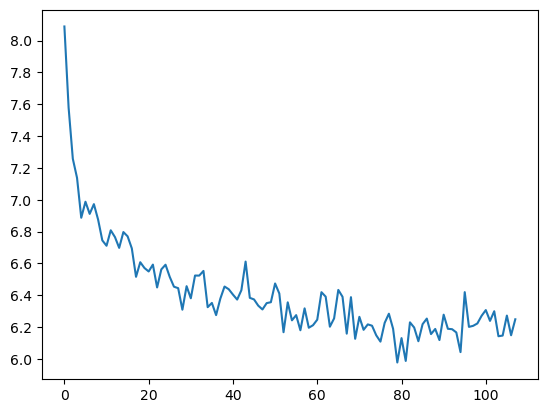

In [50]:
showPlot(plot_losses)


In [55]:
evaluateRandomly(encoder1, attn_decoder1,1)


بپوشد همی راز بر من چنین تو داناتری ای جهان آفرین/بدو گفت بیژن همه راستست ز من کار تو جمله برکاستست
به پیش صف شد از دو نیم به هر سوی بر سر نهاد <EOS>


In [62]:
evaluateRandomly(encoder1, attn_decoder1,1)

یکی بهره زیشان فرستم ببلخ بایرانیان بر کنم روز تلخ/دگر بهره بر سوی کابلستان بکابل کشم خاک زابلستان
به پیش تو گفتی که ای مرد دلیر به مردی و به دانش و چون <EOS>


In [64]:
evaluateRandomly(encoder1, attn_decoder1,1)

اگر ویژه ابری شود در بار کشنده پدر چون بود دوستدار/نخواند مرا موبد از آب پاک که بپرستم او را پدر زیر خاک
چو خورشید تابان به گفتار و کردار چون من <EOS>


# LSTM

In [65]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cs):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, states = self.lstm(output, (hidden, cs))
        hidden, c = states
        return output, hidden, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    

In [66]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cs, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, states = self.lstm(output, (hidden, cs))
        hidden , c = states
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, c, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [69]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_c0 = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_c0 = encoder(
            input_tensor[ei], encoder_hidden, encoder_c0)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cs = encoder_c0
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cs, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cs, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cs, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cs, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [74]:
plot_losses = []

In [75]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    global plot_losses
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%d %f %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0



In [76]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(dictionary, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cs = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cs = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cs)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cs = encoder_cs
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, encoder_cs,decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_cs, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(dictionary.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    

In [77]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(pair[0]+"/"+pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print(output_sentence)
    

In [80]:
hidden_size = 512
encoderlstm = EncoderRNN(dictionary.n_words, hidden_size).to(device)
attn_decoderlstm = AttnDecoderRNN(hidden_size, dictionary.n_words, dropout_p=0.1).to(device)

trainIters(encoderlstm, attn_decoderlstm, 10000, print_every=100, learning_rate=0.001)

100 1.000000 8.0618
200 2.000000 7.3208
300 3.000000 7.1821
400 4.000000 7.1697
500 5.000000 6.8268
600 6.000000 6.9187
700 7.000000 6.7796
800 8.000000 6.8954
900 9.000000 6.7809
1000 10.000000 6.6179
1100 11.000000 6.7174
1200 12.000000 6.7242
1300 13.000000 6.7136
1400 14.000000 6.6963
1500 15.000000 6.7909
1600 16.000000 6.6602
1700 17.000000 6.7722
1800 18.000000 6.5752
1900 19.000000 6.4599
2000 20.000000 6.5608
2100 21.000000 6.6835
2200 22.000000 6.5139
2300 23.000000 6.5743
2400 24.000000 6.5572
2500 25.000000 6.4427
2600 26.000000 6.5744
2700 27.000000 6.5646
2800 28.000000 6.6746
2900 29.000000 6.4153
3000 30.000000 6.3618
3100 31.000000 6.5758
3200 32.000000 6.4174
3300 33.000000 6.4268
3400 34.000000 6.2248
3500 35.000000 6.3713
3600 36.000000 6.4791
3700 37.000000 6.3401
3800 38.000000 6.4444
3900 39.000000 6.3687
4000 40.000000 6.3596
4100 41.000000 6.4523
4200 42.000000 6.4500
4300 43.000000 6.4005
4400 44.000000 6.4313
4500 45.000000 6.5629
4600 46.000000 6.4010
4700 4

In [82]:
trainIters(encoderlstm, attn_decoderlstm, 1000, print_every=100, learning_rate=0.001)

100 10.000000 6.1795
200 20.000000 6.2771
300 30.000000 6.3263
400 40.000000 6.2439
500 50.000000 6.3088
600 60.000000 6.2117
700 70.000000 6.2216
800 80.000000 6.5367
900 90.000000 6.2375
1000 100.000000 6.1480


In [83]:
len(plot_losses)

110

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

<Figure size 640x480 with 0 Axes>

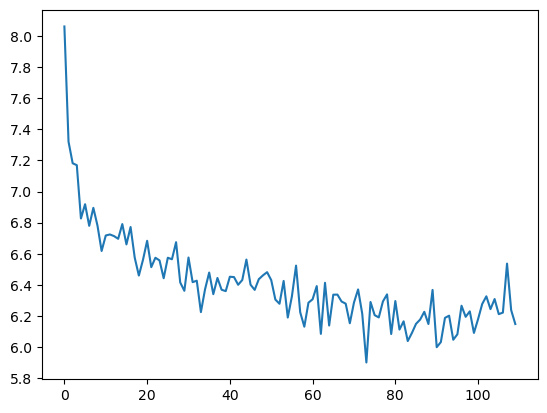

In [138]:
showPlot(plot_losses)


In [88]:
evaluateRandomly(encoderlstm, attn_decoderlstm,1)


دل شاه تا جاودان شاد باد ز کژی و ویرانی آباد باد/چو بشنید شاه این سخن گفت زه سزاوار تاجی تو این روزبه
چو بشنید با او را به سر بر تخت عاج <EOS>


In [135]:
evaluateRandomly(encoderlstm, attn_decoderlstm,1)

مرا سالیان هست هفتاد و هشت ندیدم که کشتی بروبر گذشت/بدو گفت پر مایه افراسیاب که فرخ کسی کو بمیرد در آب
چو بشنید با او را به سر به سر و رای و رای و به راه و کلاه <EOS>
